In [8]:
from autocnet_server.graph.graph import NetworkCandidateGraph
from autocnet_server.db.model import Network
from autocnet_server.config import AutoCNet_Config as config

from sqlalchemy.orm import aliased, create_session, scoped_session, sessionmaker
from sqlalchemy import create_engine

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sc = config()
db_uri = 'postgresql://{}:{}@{}:{}/{}'.format(sc.database_username,
                                              sc.database_password,
                                              sc.database_host,
                                              sc.database_port,
                                              sc.database_name)
engine = create_engine(db_uri)
connection = engine.connect()
session = sessionmaker(bind=engine)()

In [120]:
ncg = NetworkCandidateGraph.from_database()

In [115]:
from autocnet.matcher.naive_template import pattern_match
from autocnet.matcher.ciratefi import ciratefi
import cv2
from scipy.misc import bytescale

In [162]:
# 9 are punched through...
thresh = 0.5
figsize(20, 10)
res = session.query(Network).filter(Network.point_id == '3731_(956, 1046)_0')
subps = []
arrs = []
pts = []
template = None


for i, r in enumerate(res):
    sizes = [((65, 65), (51,51)), ((131, 231),(71, 151))]
    while sizes:
        size = sizes.pop()
        print(size)
        n = ncg.node[r.image_id]['data']
        if i == 0:
            exta = size[0][0]
            extb = size[0][1]
            img = cv2.equalizeHist(bytescale(n.geodata.read_array(pixels=(int(r.x-exta/2), int(r.y-extb/2), exta, extb))))
            arrs.append(img)
            pts.append((exta/2, extb/2))
        else:
            exta = size[1][0]
            extb = size[1][1]
            tmp = cv2.equalizeHist(bytescale(n.geodata.read_array(pixels=(int(r.x-exta/2), int(r.y-extb/2), exta, extb))))
            subp = pattern_match(tmp, img, upsampling=8, func=5)
            if subp[-1] > thresh:
                break
        pts.append((exta/2 + subp[0], extb/2+subp[1]))
        subps.append(subp)
        arrs.append(tmp)


((131, 231), (71, 151))
((65, 65), (51, 51))
((131, 231), (71, 151))
((65, 65), (51, 51))
((131, 231), (71, 151))


/home/jlaura/anaconda3/envs/ct/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jlaura/anaconda3/envs/ct/lib/python3.6/site-packages/ipykernel/__main__.py:26: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


((65, 65), (51, 51))
((131, 231), (71, 151))
((65, 65), (51, 51))
((131, 231), (71, 151))
((65, 65), (51, 51))
((131, 231), (71, 151))
((65, 65), (51, 51))
((131, 231), (71, 151))
((65, 65), (51, 51))
((131, 231), (71, 151))
((65, 65), (51, 51))
((131, 231), (71, 151))
((65, 65), (51, 51))


In [163]:
subps

[(7.0, -85.75, 0.37138259410858154),
 (7.0, -85.75, 0.37138259410858154),
 (7.0, -85.75, 0.37138259410858154),
 (-1.0, -0.25, 0.3741269111633301),
 (6.25, -101.5, 0.25754106044769287),
 (-7.0, 7.0, 0.13128098845481873),
 (5.0, -121.25, 0.0819261446595192),
 (-7.0, 1.875, 0.0686398446559906),
 (4.0, -109.75, 0.05868704989552498),
 (-4.125, -6.125, 0.04140319675207138),
 (9.0, -91.5, 0.11123401671648026),
 (-7.0, 6.0, 0.12545748054981232),
 (6.625, -88.625, 0.10639595240354538),
 (6.5, 1.625, 0.09611284732818604),
 (7.375, -95.875, 0.23099011182785034),
 (-3.125, 6.5, 0.15026696026325226),
 (9.0, -79.0, 0.06861572712659836),
 (-6.75, 5.125, 0.08541370928287506)]

(7.0, -85.75, 0.37138259410858154)
(7.0, -85.75, 0.37138259410858154)
(7.0, -85.75, 0.37138259410858154)
(-1.0, -0.25, 0.3741269111633301)
(6.25, -101.5, 0.25754106044769287)
(-7.0, 7.0, 0.13128098845481873)
(5.0, -121.25, 0.0819261446595192)
(-7.0, 1.875, 0.0686398446559906)
(4.0, -109.75, 0.05868704989552498)


IndexError: index 9 is out of bounds for axis 0 with size 9

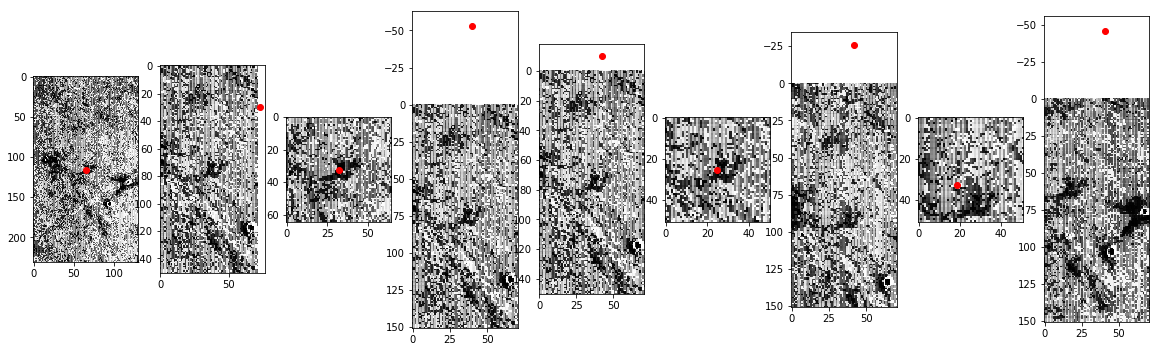

In [164]:
fig, axes = plt.subplots(1,9)
for i in range(len(arrs)):
    if i > 0:
        print(subps[i-1])
    axes[i].imshow(arrs[i], cmap='Greys')
    axes[i].plot(*pts[i], 'ro')

In [167]:
from autocnet_server.cluster.slurm import spawn

In [174]:
import glob
import os

In [192]:
jbs = []
for f in glob.glob('split_*'):
    newp = os.path.splitext(f)[0] + '_subp.net'
    fromlist = '/home/jlaura/autocnet_server/notebooks/ctx.lis'
    def_file = '/home/jlaura/autocnet_server/notebooks/pointreg_P51x51_S65x65.def'
    cmd = 'source ~isis3mgr/bin/initIsis.sh isis3\npointreg fromlist={} cnet={} deffile={} onet={}'.format(fromlist, f, def_file, newp)
    jbs.append(spawn(cmd, name='PointReg', time='06:00:00'))

In [197]:
jbs = []
for f in glob.glob('split_*_subp.net'):
    newp = os.path.splitext(f)[0] + '_2pass.net'
    fromlist = '/home/jlaura/autocnet_server/notebooks/ctx.lis'
    def_file = '/home/jlaura/autocnet_server/notebooks/point_reg.def'
    cmd = 'source ~isis3mgr/bin/initIsis.sh isis3\npointreg fromlist={} cnet={} deffile={} onet={} measures=candidates'.format(fromlist, f, def_file, newp)
    jbs.append(spawn(cmd, name='PointReg', time='06:00:00'))

In [200]:
jbs = []
for f in glob.glob('/scratch/jlaura/ctx/cal/*.cub'):
    cmd = 'source ~isis3mgr/bin/initIsis.sh isis3\nfootprintinit from={}'.format(f)
    jbs.append(spawn(cmd, name='FPI', time='01:00:00'))

In [194]:
!cat /home/jlaura/autocnet_server/notebooks/point_reg.def

Object = AutoRegistration
  Group = Algorithm
    Name            = MaximumCorrelation
    Tolerance       = 0.5
  End_Group

  Group = PatternChip
    Samples       = 71
    Lines         = 151
  End_Group

  Group = SearchChip
    Samples = 131
    Lines   = 231
  End_Group

  Group = SurfaceModel
    DistanceTolerance = 1.5
    WindowSize        = 7
  End_Group
End_Object
End

